In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import GradientBoostingRegressor

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [2]:
dowhy.__version__

'0.8'

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Chapter 09



## Matching

### Read the data

In [486]:
earnings_data = pd.read_csv(r'./data/ml_earnings.csv')

In [487]:
earnings_data.head()

,age,took_a_course,earnings
0,23,False,121116.0
1,21,False,117259.0
2,20,False,114255.0
3,27,True,149745.0
4,35,False,167346.0


In [488]:
earnings_data.groupby(['age', 'took_a_course']).mean()

earnings
age took_a_course               
19  True           121469.600000
20  False          114157.600000
    True           125669.333333
21  False          116939.500000
    True           130039.500000
22  False          122772.000000
    True           131769.500000
23  False          124478.727273
    True           136766.333333
24  False          129073.600000
    True           138354.500000
25  False          130698.600000
    True           143773.000000
26  False          133959.000000
    True           144180.666667
27  False          137579.000000
    True           148268.500000
28  False          142000.000000
    True           151697.333333
29  False          146526.800000
    True           154485.000000
30  False          149496.857143
31  False          154193.000000
    True           163721.000000
32  False          157963.500000
34  True           177431.000000
35  False          167346.000000
    True           179912.000000
36  False          175026.000000
37  False          178358.500000
    True           193482.000000
38  False          184782.000000
    True           190250.000000
39  False          189791.000000
40  True           206640.500000
41  False          198271.000000
42  False          202103.000000
43  False          208940.000000
    True           218605.000000
45  False          223342.000000
46  False          226191.000000
47  False          234218.000000
    True           237966.000000

### Define the graph

In [464]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [480]:
data.query('took_a_course==1')['earnings'].mean() - data.query('took_a_course==0')['earnings'].mean()

In [481]:
# Instantiate the CausalModel 
model = CausalModel(
    data=data,
    treatment='took_a_course',
    outcome='earnings',
    graph=gml_string
)


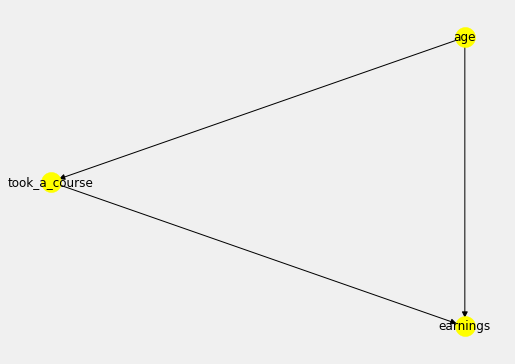

In [482]:
model.view_model()

In [483]:
# Get the estimand
estimand = model.identify_effect()

# Get estimate (Linear Regression)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name="backdoor.distance_matching",
    target_units="ate",
    method_params={'distance_metric': "minkowski", 'p':2})

distance_matching


In [484]:
estimate.value

## Propensity scores

### Probability of finding at least one match per row

In [12]:
results_per_dimension = {}

for d in range(2, 19):
    results = []
    
    N_SAMPLES = 1000
    DIM_X = d

    for i in tqdm(range(100)):

        X = np.random.binomial(n=1, p=.5, size=(N_SAMPLES, DIM_X))

        local_results = []

        for row in range(X.shape[0]):
            # Did we find at least 1 match for `row`?
            success = (np.where(np.where(X == X[row], 1, 0).sum(axis=1) == DIM_X, 1, 0).sum() - 1) > 0
            local_results.append(success)

        results.append(np.array(local_results).mean())
        
    results_per_dimension[d] = results

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.40it/s]


In [13]:
# Compute statistics
mean_p = pd.DataFrame(results_per_dimension).mean(axis=0).values
sd_p = pd.DataFrame(results_per_dimension).std(axis=0).values

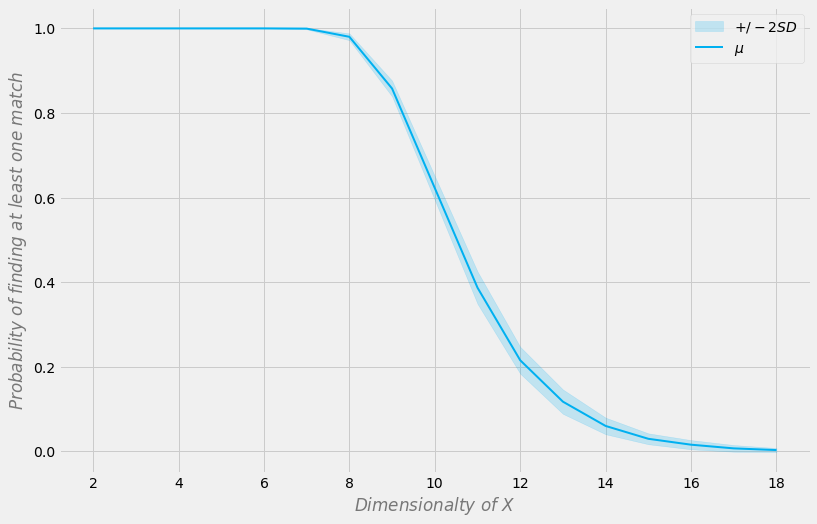

In [57]:
# Plot
plt.figure(figsize=(12, 8))
plt.fill_between(range(2, 19), mean_p - sd_p*2, mean_p + sd_p*2, color=COLORS[0], alpha=.2, label='$+/-2SD$')
plt.plot(range(2, 19), mean_p, color=COLORS[0], lw=2, label='$\mu$')
plt.legend()
plt.xlabel('$Dimensionalty \ of \ X$', alpha=.5)
plt.ylabel('$Probability \ of \ finding \ at \ least \ one \ match$', alpha=.5)
plt.show()

## Inverse Probability Weighting

## S-Learner: The Lone Ranger